# Prepare Data Set

First, a data set is loaded. Function `load_data_from_df` automatically saves calculated features to the provided data directory (unless `use_data_saving` is set to `False`). Every next run will use the saved features.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch

os.chdir('src')

In [9]:
import numpy as np

In [2]:
from featurization.data_utils import load_data_from_df, construct_loader

In [3]:
batch_size = 64

# Formal charges are one-hot encoded to keep compatibility with the pre-trained weights.
# If you do not plan to use the pre-trained weights, we recommend to set one_hot_formal_charge to False.
X, y = load_data_from_df('../data/freesolv/freesolv.csv', one_hot_formal_charge=True)
data_loader = construct_loader(X, y, batch_size)

You can use your data, but the CSV file should contain two columns as shown below:

In [4]:
df = pd.read_csv('../data/freesolv/freesolv.csv')

# Prepare Model

In [5]:
from transformer import make_model

In [6]:
d_atom = X[0][0].shape[1]  # It depends on the used featurization.

model_params = {
    'd_atom': d_atom,
    'd_model': 1024,
    'N': 8,
    'h': 16,
    'N_dense': 1,
    'lambda_attention': 0.33, 
    'lambda_distance': 0.33,
    'leaky_relu_slope': 0.1, 
    'dense_output_nonlinearity': 'relu', 
    'distance_matrix_kernel': 'exp', 
    'dropout': 0.0,
    'aggregation_type': 'mean'
}

model = make_model(**model_params)

# Load Pretrained Weights (optional)

If you want to use the pre-trained weights to train your model, **you should not change model parameters in the cell above**.

In [10]:
pretrained_name = '../pretrained_weights.pt'  # This file should be downloaded first (See README.md).
pretrained_state_dict = torch.load(pretrained_name)

In [11]:
model_state_dict = model.state_dict()
for name, param in pretrained_state_dict.items():
    if 'generator' in name:
         continue
    if isinstance(param, torch.nn.Parameter):
        param = param.data
    model_state_dict[name].copy_(param)

# Run Training/Evaluation Loop

In [12]:
batch = next(iter(data_loader))

/Users/piotrhelm/Desktop/IN/IN-21:22Z/MAT/src/featurization/data_utils.py:270: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return [FloatTensor(features) for features in (adjacency_list, features_list, distance_list, labels)]


In [20]:
class Molecule:
    def __init__(self, distances_matrix, adj_matrix, edges_att):
        self.distances_matrix = distances_matrix
        self.adj_matrix = adj_matrix
        self.edges_att = edges_att

In [14]:
adjacency_matrix, node_features, distance_matrix, y = batch
batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
output = model(node_features, node_features, batch_mask, batch_mask, Molecule(adjacency_matrix, distance_matrix, None))

torch.Size([64, 20, 1024])


# Optimizer

In [7]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

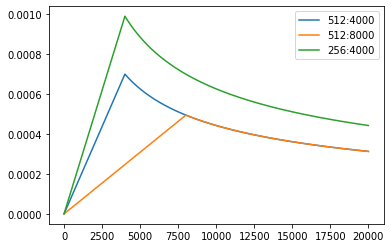

In [10]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

# TRAINING

In [22]:
# Train the simple copy task.
criterion = torch.nn.MSELoss()
opt = NoamOpt(1024, 1, 400,
                    torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9))

model.train()
for epoch in range(10):
    running_loss = 0
    for i, batch in enumerate(data_loader):
        adjacency_matrix, node_features, distance_matrix, y = batch
        batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
        output = model(node_features, node_features, batch_mask, batch_mask, 
                       Molecule(adjacency_matrix, distance_matrix, None))

        opt.optimizer.zero_grad()
        loss = criterion(node_features,output)
        loss.backward()
        opt.optimizer.step()
        running_loss += loss.item()
        mean_loss = running_loss/(i+1)
        print(mean_loss)

torch.Size([64, 21, 1024])
0.8600534200668335
torch.Size([64, 20, 1024])
0.9688307642936707
torch.Size([64, 20, 1024])
0.9725370605786642
torch.Size([64, 23, 1024])
0.9442355930805206
torch.Size([64, 25, 1024])
0.9251914024353027
torch.Size([64, 23, 1024])
0.9148935278256735
torch.Size([64, 24, 1024])
0.9053358691079276
torch.Size([64, 24, 1024])
0.8990575298666954
torch.Size([64, 19, 1024])
0.9193016754256355
torch.Size([64, 24, 1024])
0.9117730498313904
torch.Size([2, 8, 1024])
0.9828810583461415
torch.Size([64, 22, 1024])
0.9044512510299683
torch.Size([64, 25, 1024])
0.8636302053928375
torch.Size([64, 24, 1024])
0.8629469275474548
torch.Size([64, 20, 1024])
0.897810235619545
torch.Size([64, 23, 1024])
0.8847322702407837
torch.Size([64, 20, 1024])
0.89662304520607
torch.Size([64, 24, 1024])
0.8932460461344037
torch.Size([64, 20, 1024])
0.9016529247164726
torch.Size([64, 24, 1024])
0.9058128197987875
torch.Size([64, 23, 1024])
0.9001437485218048
torch.Size([2, 12, 1024])
0.93187276341

KeyboardInterrupt: 